In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants as const
import json
import os

import jampy as jam 
from adamet.adamet import adamet
from adamet.adamet import corner_plot
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield
from pafit.fit_kinematic_pa import fit_kinematic_pa
from astropy.cosmology import FlatLambdaCDM

from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

In [12]:
workpath = '.'
name = 'NGC3379'
path = workpath +'/'+name+'/cyl-psf'
mgefile = workpath +'/mge/mge_%s.dat'%name
kinfile = workpath + '/kinematics/kinematics_oasis_%s.fits'%name

print('Path:',path)

z = 0.003026
cz = z*const.c.to('km/s').value
cosmo = FlatLambdaCDM(70, 0.3)
print('z:', z)
print('z distance:', cosmo.comoving_distance(z))
# distance = cosmo.comoving_distance(z).to_value()
dist_mod = 30.06
distance = 10*10**(dist_mod/5-6)
print('Distance: %.2f Mpc'%distance)
print('Scale: %.4f pc/arcsec'%(distance/206265*1e6))

distance*np.pi/0.648

if not os.path.exists(path):
    os.makedirs(path)

Path: ./NGC3379/cyl-psf
z: 0.003026
z distance: 12.95077037656492 Mpc
Distance: 10.28 Mpc
Scale: 49.8396 pc/arcsec


[[ 4.264 -1.314  0.9  ]
 [ 4.21  -0.771  0.9  ]
 [ 4.182 -0.197  0.926]
 [ 4.167  0.045  0.895]
 [ 3.939  0.34   0.85 ]
 [ 3.907  0.493  0.929]
 [ 3.354  0.782  0.852]
 [ 3.455  0.87   0.967]
 [ 2.902  1.111  0.85 ]
 [ 2.728  1.43   0.866]
 [ 2.287  1.685  0.85 ]
 [ 1.645  2.008  0.901]
 [ 1.108  2.4    0.861]]
Reff: 64.85490948850847


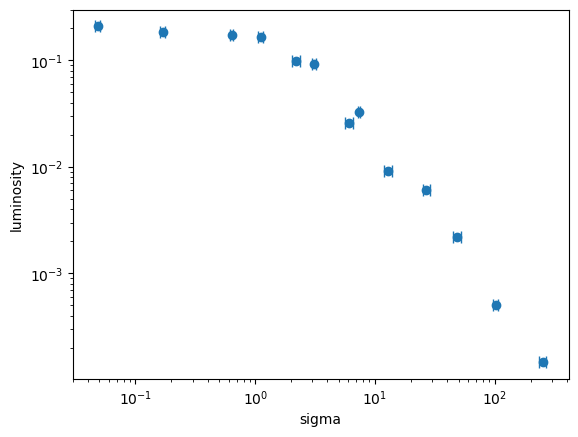

In [13]:
# MGE Parameters
mgeload = np.loadtxt(mgefile, delimiter='|',usecols=[1,2,3],skiprows=1)
surf, sigma, qObs = mgeload.T
print(mgeload)

surf = 10**surf
sigma = 10**sigma

print('Reff:',jam.mge.half_light_radius(surf, sigma, qObs)[0])
# surf, sigma, qObs = np.loadtxt('../MaNGA_data/mge_parms.txt').T

# name = '8481-3702'
# name = '11958-12704'

# surf, sigma, qObs = np.loadtxt('../MaNGA_data/SDSSDR17_MaNGA_MGE/MGE/%s.dat'%name,skiprows=3).T
# print(surf, sigma, qObs)

plt.errorbar(sigma, surf/np.sum(surf), xerr=[sigma*(1-qObs)/2], fmt='o',capsize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('sigma')
plt.ylabel('luminosity')

np.savetxt('%s/mge_parms.dat'%path,np.vstack([surf, sigma, qObs]).T, fmt=['%10.4e','%8.2f','%8.3f'], header='%s MGE'%name) #I_j (L_(sun,I)*pc-2), sigma_j (arcsec), q_j

In [17]:
# OASIS data
oasis_kin = fits.open(kinfile)
# oasis_kin.info()
header = oasis_kin[1].header
data = oasis_kin[1].data

xbin0 = data['XBIN'][0]
ybin0 = data['YBIN'][0]
vel0 = data['VEL'][0] - cz
dvel = data['DVEL'][0]
sig = data['SIG'][0]
dsig = data['DSIG'][0]
xpix = data['XPIX'][0]
ypix = data['YPIX'][0]
binnum = data['BINNUM'][0]
flux = data['SURF'][0]

oasis_kin.close()
# filename = '../MaNGA_data/mange_kinematic_map.txt'
# xbin, ybin, rms, erms, flux = np.loadtxt(filename).T

Lum-weighted vel: 41.62878
  Kin PA:  75.5  +/-   5.2  (3*sigma error)
Velocity Offset: -0.16


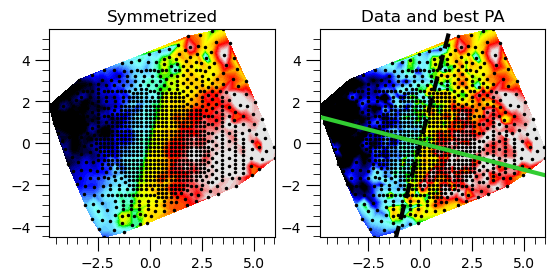

In [15]:
# vel correction
offset = np.average(vel0[binnum],weights=flux)
print('Lum-weighted vel:',offset)
vel = vel0 - offset

pafit = fit_kinematic_pa(xbin0,ybin0,vel,dvel=dvel,debug=False)
vel -= pafit[2]

# pa correction
pa = 90-pafit[0] #kinematic PA
#pa = 19.5 #photometry PA

pa_rad = pa/180*np.pi
xbin = xbin0*np.cos(pa_rad) - ybin0*np.sin(pa_rad)
ybin = ybin0*np.cos(pa_rad) + xbin0*np.sin(pa_rad)

# get rms 
rms = np.linalg.norm([vel, sig],axis=0)
erms = np.linalg.norm([vel*dvel, sig*dsig],axis=0)/rms
# erms = np.linalg.norm([dvel, dsig],axis=0)
goodbins = np.isfinite(rms)  # Here we fit all bins
rms1 = rms.copy()
rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])

vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])

np.savetxt('%s/kinematics.dat'%path, np.vstack([xbin,ybin,rms,erms, goodbins]).T, fmt='%10.5f', header=' xbin | ybin | Vrms | eVrms | isGoodBin')

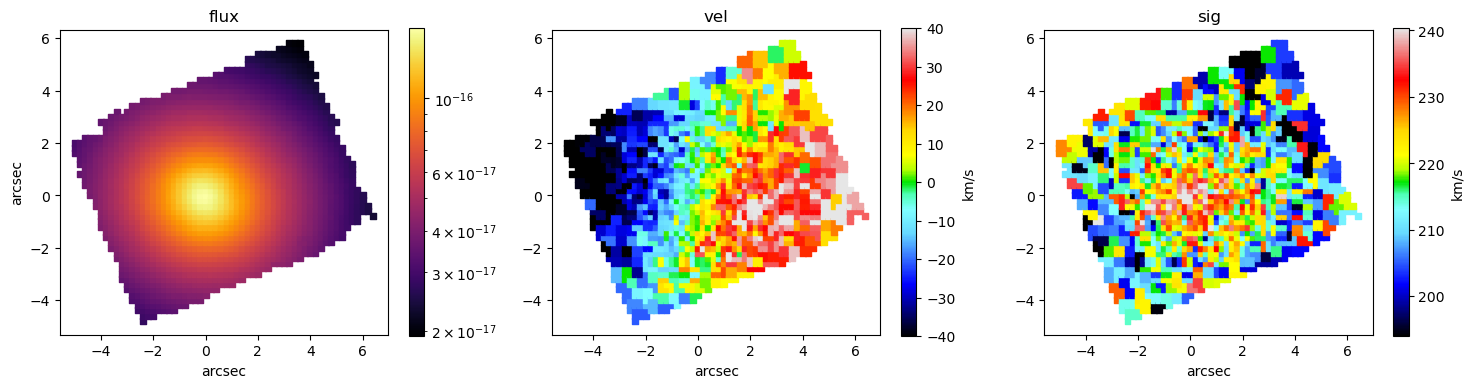

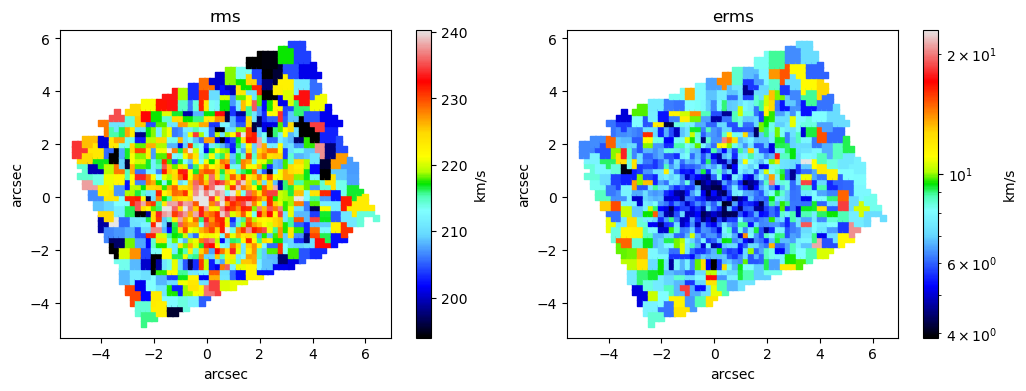

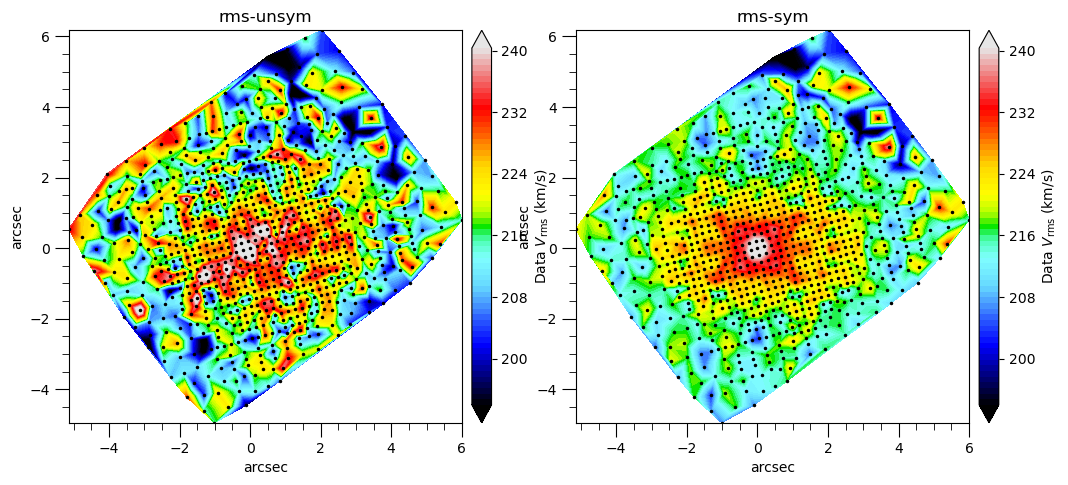

In [16]:
# kinematic maps
# vmin = 190
# vmax = 245
velrange = 40
t = mpl.markers.MarkerStyle(marker='s')
size = 18
# t._transform = t.get_transform().rotate_deg(pa)

plt.figure(figsize=[18,4])
plt.subplot(1,3,1)
plt.scatter(xpix,ypix,marker=t,s=size,c=flux,cmap='inferno',norm='log')
plt.colorbar()
plt.axis('scaled')
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('flux')

plt.subplot(1,3,2)
plt.scatter(xpix,ypix,marker=t,s=size,c=vel[binnum],cmap='sauron', vmax=velrange,vmin=-velrange)
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.title('vel')

plt.subplot(1,3,3)
plt.scatter(xpix,ypix,marker=t,s=size,c=sig[binnum],cmap='sauron', vmax=vmax, vmin=vmin)
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.title('sig')
plt.show()

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.scatter(xpix,ypix,marker=t,s=size,c=rms[binnum],cmap='sauron', vmax=vmax, vmin=vmin)
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('rms')

plt.subplot(1,2,2)
plt.scatter(xpix,ypix,marker=t,s=size,c=erms[binnum],cmap='sauron', norm='log')
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('erms')
plt.show()

plt.figure(figsize=[12,10])
plt.subplot(1,2,1)
plot_velfield(xbin, ybin, rms, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)")
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('rms-unsym')
plt.axis('scaled')

plt.subplot(1,2,2)
plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)")
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('rms-sym')
plt.axis('scaled')
plt.show()

In [78]:
# sauron_kin = fits.open('../SAURON_data/PXF_bin_MS_NGC3379_r1_idl.fits')
# sauron_kin.info()
# header = sauron_kin[1].header
# print(header)
# data = sauron_kin[1].data

# xbin0 = data['XS']
# ybin0 = data['YS']
# vel0 = data['VPXF'] - cz
# dvel = data['EVPXF']
# sig = data['SPXF']
# dsig = data['ESPXF']
# # xpix = data['XPIX'][0]
# # ypix = data['YPIX'][0]
# # binnum = data['BINNUM'][0]
# flux = data['FLUX']

# sauron_kin.close()
# # filename = '../MaNGA_data/mange_kinematic_map.txt'
# # xbin, ybin, rms, erms, flux = np.loadtxt(filename).T

In [79]:
# offset = np.average(vel0,weights=flux)
# print('Vel offset:',offset)
# vel = vel0 - offset

# rms = np.linalg.norm([vel, sig],axis=0)
# erms = np.linalg.norm([dvel, dsig],axis=0)

# pa = 15 #kinematic PA
# #pa = 19.5 #photometry PA

# pa_rad = pa/180*np.pi

# xbin = xbin0*np.cos(pa_rad) - ybin0*np.sin(pa_rad)
# ybin = ybin0*np.cos(pa_rad) + xbin0*np.sin(pa_rad)

In [80]:
# # plt.figure(figsize=[8,8])
# # plt.tripcolor(xpix[0],ypix[0],flux[0])
# # plt.tripcolor(xbin,ybin,vel,cmap='RdBu')

# # plt.tripcolor(xpix,ypix,vel[binnum],cmap='sauron')
# vmin, vmax = np.percentile(sig, [0.5, 99.5])

# velrange = 80

# size = 5
# t = mpl.markers.MarkerStyle(marker='s')
# # t._transform = t.get_transform().rotate_deg(pa)

# plt.scatter(xbin0,ybin0,marker=t,s=size,c=flux,cmap='inferno',norm='log')
# plt.colorbar()
# plt.axis('scaled')
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('flux')
# plt.show()

# plt.scatter(xbin0,ybin0,marker=t,s=size,c=vel,cmap='sauron', vmax=velrange,vmin=-velrange)
# plt.colorbar(label=r"km/s")
# plt.axis('scaled')
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('vel')
# plt.show()

# plt.scatter(xbin0,ybin0,marker=t,s=size,c=sig,cmap='sauron', vmax=vmax, vmin=vmin)
# plt.colorbar(label=r"km/s")
# plt.axis('scaled')
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('sig')
# plt.show()

# plt.scatter(xbin0,ybin0,marker=t,s=size,c=rms,cmap='sauron', vmax=vmax, vmin=vmin)
# plt.colorbar(label=r"km/s")
# plt.axis('scaled')
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('rms')
# plt.show()

# plt.scatter(xbin0,ybin0,marker=t,s=size,c=erms,cmap='sauron', norm='log')
# plt.colorbar(label=r"km/s")
# plt.axis('scaled')
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('erms')
# plt.show()

In [81]:
# plt.figure(figsize=[10,10])
# vmin, vmax = np.percentile(rms, [0.5, 99.5])
# plot_velfield(xbin, ybin, rms, vmin=vmin, vmax=vmax, linescolor='w',
#                   colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)")
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
# plt.title('rms')
# plt.axis('scaled')
# plt.show()


In [19]:
# Starting guess, e.g. from a previous least-squares fit
q0 = 0.75
ratio0 = 1.0    # anisotropy ratio sigma_z/sigma_R
lg_bh0 = 8.6
lg_ml0 = 0.5
f_dm0 = 0.5
lg_rb0 = 3
psfscale0 = 1

# Typical Adaptive-Optics PSF: narrow core + broad wings
sigmapsf = [0.94/2.355, 4.31/2.355]  # sigma PSF in arcsec
normpsf = [0.84, 0.16]
pixsize = 1
print('PSF:',sigmapsf)

qmin = np.min(qObs)
print('qmin:',qmin)
p0 = [q0, ratio0, lg_bh0, lg_ml0, f_dm0, lg_rb0, psfscale0]
idfit = [1,2,3,6]

bounds = [[0.5, 0.5, lg_bh0-2, lg_ml0-1, 0, -1, 0]
          ,[qmin, 1.5, lg_bh0+2, lg_ml0+0.2, 1, 7, 1]]
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg M_{\rm BH}$"
          , r"$\lg(M/L)_{\rm tot}$", r"$f_{\rm DM}$", r"$\lg r_b$", r"PSFscale"]
sigpar = np.array([0.1, 0.005, 0.01, 0.005, 0.05, 0.1, 0.1])  # crude estimate of uncertainties

nstep = 10000


PSF: [0.39915074309978765, 1.830148619957537]
qmin: 0.85


In [20]:
jam_dict = {'name':name, 'nstep':nstep, 'labels':labels, 'p0':p0
            ,'idfit':idfit, 'sigpar':sigpar.tolist(), 'bounds':bounds, 'sigmapsf':sigmapsf
            , 'normpsf':normpsf, 'distance':distance, 'pixsize':pixsize}

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open('%s/jam_pars.json'%path, "w") as parmfile:
    json.dump(jam_dict, parmfile, indent=4, cls=NumpyEncoder)

In [85]:
# ! python3 ./jam.py -p $path

In [86]:
path = './NGC3379/cyl-psf'
res = np.loadtxt('%s/jam_lnprob.dat'%path)
idfit = [1,2,3]
pars = res[100:,:-1]
lnprob = res[100:,-1]
rms_model, flux_model = np.loadtxt('%s/model.dat'%path).T[2:]

print(path)
print('nstep:',len(lnprob))

./NGC3379-cyl-psf1
nstep: 9900



Best-fitting parameters and 1sigma errors:
   $\sigma_z/\sigma_R$ = 0.9995 +/- 0.0047
   $\lg M_{\rm BH}$ = 8.629 +/- 0.011
   $\lg(M/L)_{\rm tot}$ = 0.5181 +/- 0.0018
i= nan +/- nan °
Initial guess: [0.75, 1.0, 8.6, 0.5, 0.5, 3, 0.25]


/var/folders/x6/vzdv6mnd53x3y42421smcsym0000gn/T/ipykernel_8927/1785307461.py:19: RuntimeWarning: invalid value encountered in sqrt
  inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - (bestfit[0])**2)))
/var/folders/x6/vzdv6mnd53x3y42421smcsym0000gn/T/ipykernel_8927/1785307461.py:20: RuntimeWarning: invalid value encountered in sqrt
  inc2 = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - (bestfit[0]-sig_bestfit[0])**2)))


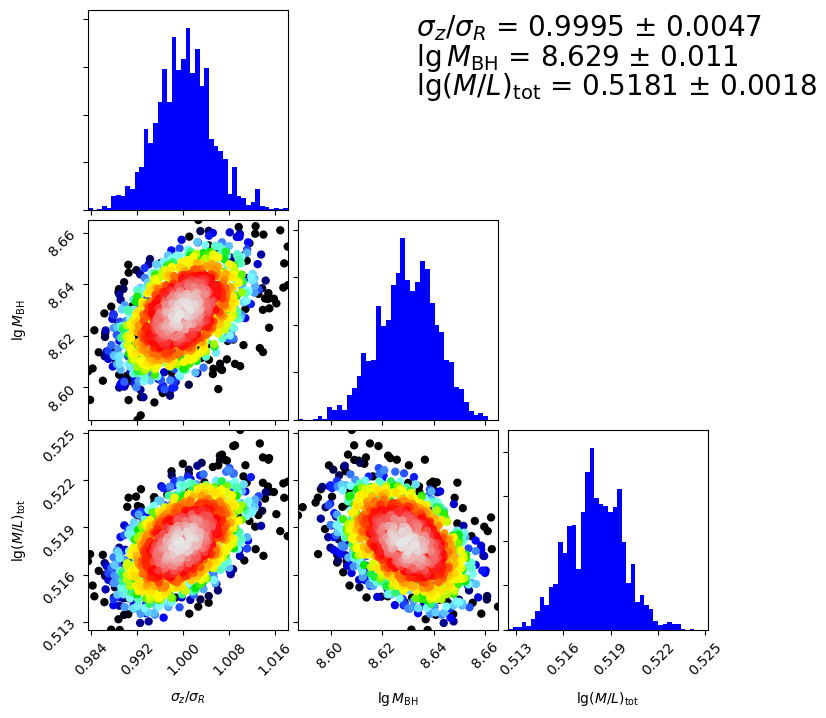

In [87]:
bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
perc = np.percentile(pars, [15.86, 84.14], axis=0)
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of 68% interval

labelsfit = np.array(labels)[idfit]
# fig = corner_plot(pars, lnprob, labels=labels, extents=[[0.5, bestfit[1]-0.15, bestfit[2]-0.2, bestfit[3]-0.02], [qmin, bestfit[1]+0.15, bestfit[2]+0.2, bestfit[3]+0.02]])
fig = corner_plot(pars, lnprob, labels=labelsfit)
# fig = corner_plot(pars, lnprob, labels=labelsfit, extents=[[0.5, 0.9, lg_bh0-1, lg_ml0-0.2, 0,1]
        #   ,[qmin, 1.1, lg_bh0+0.5, lg_ml0+0.2, 0.5,4]])

print("\nBest-fitting parameters and 1sigma errors:")
i = 0
for label, best, sigf in zip(labelsfit, bestfit, sig_bestfit):
    print(f"   {label} = {best:#.4g} +/- {sigf:#.2g}")
    fig.text(0.55,0.95-0.04*i,f"   {label} = {best:#.4g} $\pm$ {sigf:#.2g}",fontsize=20)
    i+=1

qmin = np.min(qObs)
inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - (bestfit[0])**2)))
inc2 = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - (bestfit[0]-sig_bestfit[0])**2)))
print('i=', inc,'+/-',inc - inc2, '°')

print('Initial guess:',p0)

# corner_plot(pars, lnprob, labels=labels, extents=bounds)

# plt.colorbar()

fig.savefig('./%s/corner.png'%name)

In [88]:
# mbhlist[1]=bestfit[2]
# mllist[1]=bestfit[3]

# plt.plot(psflist,mbhlist,'o-')
# plt.show()
# plt.plot(psflist,mllist,'o-')
# plt.show()

In [89]:
# psflist = [1,0.75,0.5]
# mbhlist = [0,0,0]
# mllist = [0,0,0]

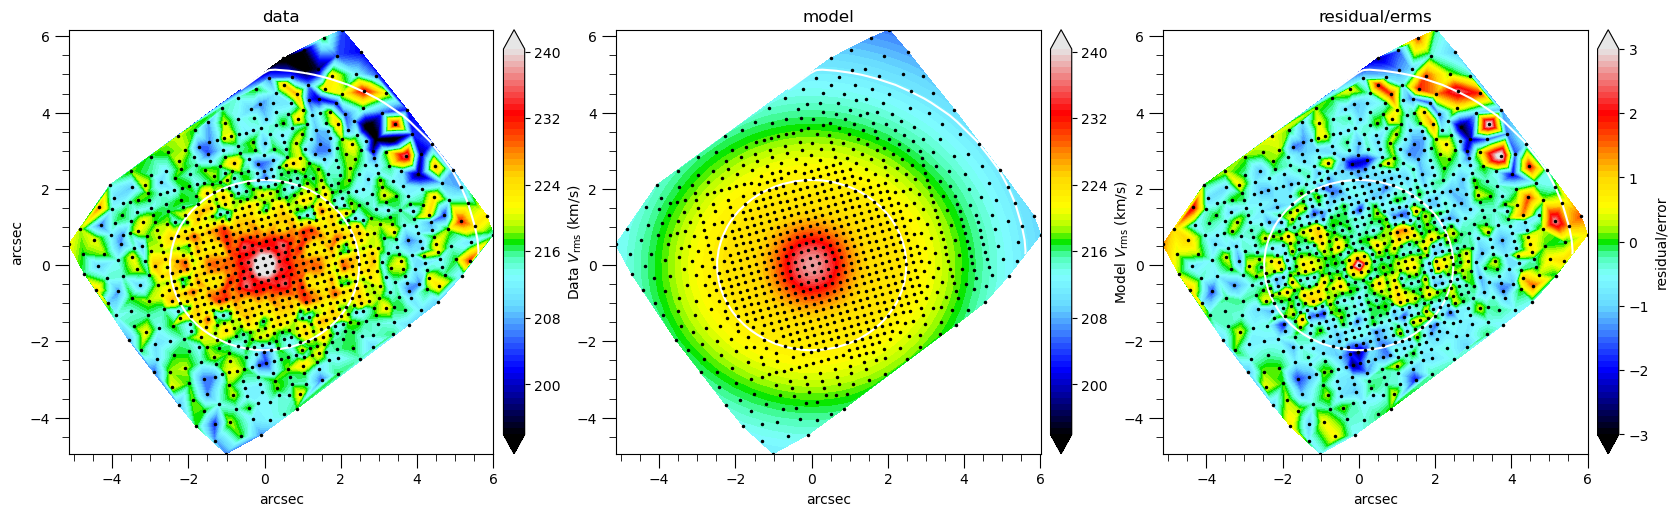

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model)
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('data')

plt.subplot(1,3,2)
plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model)
plt.xlabel('arcsec')
# plt.ylabel('arcsec')
plt.title('model')

plt.subplot(1,3,3)
rel_res = (rms1-rms_model)/erms

resrange = 3

plot_velfield(xbin, ybin, rel_res, vmin=-resrange, vmax=resrange, linescolor='w',
                  colorbar=1, label=r"residual/error", flux=flux_model)
plt.xlabel('arcsec')
# plt.ylabel('arcsec')
plt.title('residual/erms')
plt.show()

plt.tight_layout()
plt.show()

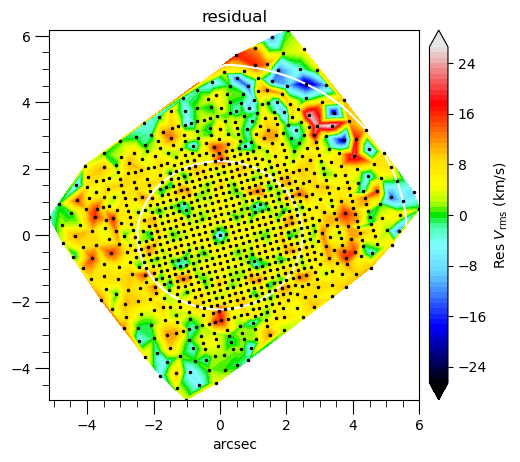

In [ ]:
resrange = np.max(np.abs(rms_model-rms1))
plot_velfield(xbin, ybin, rms_model-rms1, vmin=-resrange,vmax=resrange, linescolor='w',
                  colorbar=1, label=r"Res $V_{\rm rms}$ (km/s)", flux=flux_model)
plt.xlabel('arcsec')
# plt.ylabel('arcsec')
plt.title('residual')

plt.show()

In [ ]:
# rms_model1 = rms_model

54


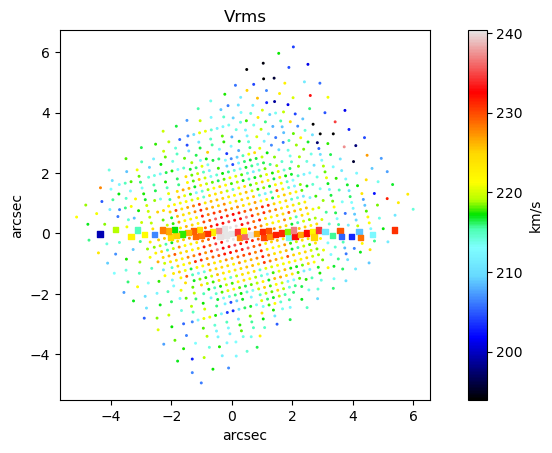

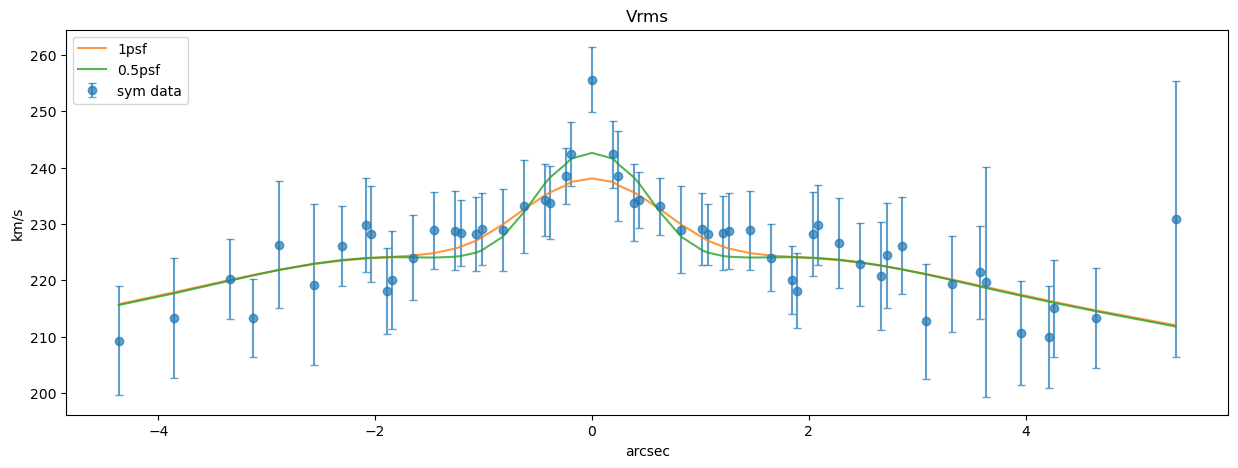

In [ ]:
slit = 0.3
theta = 0/180*np.pi
slit_bin = np.where(np.abs(ybin*np.cos(theta)-xbin*np.sin(theta))<slit/2)
rbin = xbin[slit_bin]*np.cos(theta)+ybin[slit_bin]*np.sin(theta)
sort_slit = np.argsort(rbin)

print(len(slit_bin[0]))
plt.scatter(xbin,ybin,marker='.',s=5,c=rms1,cmap='sauron', vmax=vmax,vmin=vmin)
plt.scatter(xbin[slit_bin],ybin[slit_bin],marker='s',s=15,c=rms[slit_bin],cmap='sauron', vmax=vmax,vmin=vmin)
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('Vrms')
plt.show()

plt.figure(figsize=[15,5])
plt.errorbar(rbin[sort_slit], rms1[slit_bin][sort_slit], erms[slit_bin][sort_slit], fmt='o',capsize=3,alpha=0.7,label='sym data')
# plt.errorbar(rbin[sort_slit], rms[slit_bin][sort_slit], erms[slit_bin][sort_slit], fmt='o',capsize=3, alpha=0.8,label='unsym data')

plt.plot(rbin[sort_slit],rms_model[slit_bin][sort_slit], '-',label='1psf', alpha=0.8)
# plt.plot(rbin[sort_slit],rms_model2[slit_bin][sort_slit], '-',label='0.75psf', alpha=0.8)
plt.plot(rbin[sort_slit],rms_model1[slit_bin][sort_slit], '-',label='0.5psf', alpha=0.8)
# plt.axvline(0)
plt.xlabel('arcsec')
plt.ylabel(r"km/s")
plt.legend()
plt.title('Vrms')
plt.show()


50


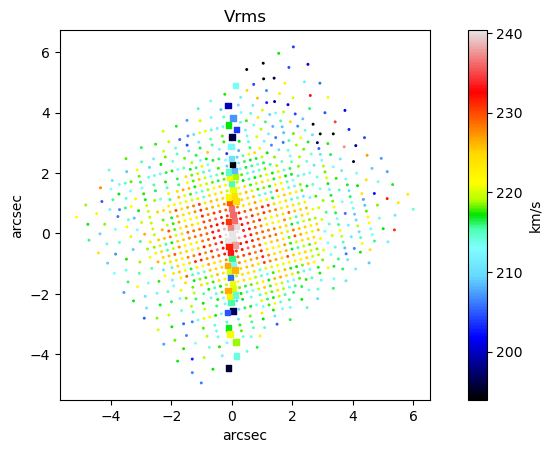

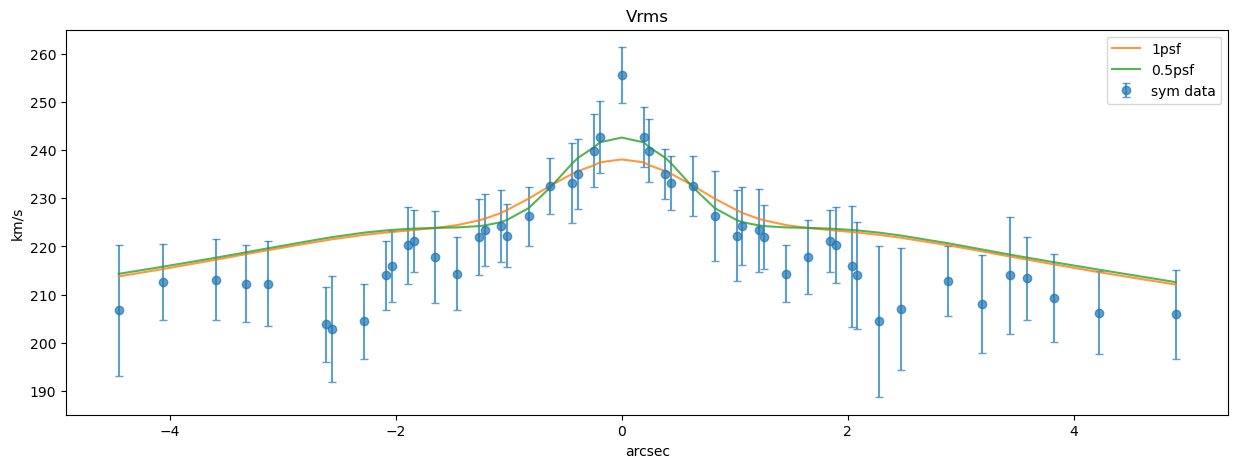

In [ ]:
slit = 0.3
theta = 90/180*np.pi
slit_bin = np.where(np.abs(ybin*np.cos(theta)-xbin*np.sin(theta))<slit/2)
rbin = xbin[slit_bin]*np.cos(theta)+ybin[slit_bin]*np.sin(theta)
sort_slit = np.argsort(rbin)

print(len(slit_bin[0]))
plt.scatter(xbin,ybin,marker='.',s=5,c=rms1,cmap='sauron', vmax=vmax,vmin=vmin)
plt.scatter(xbin[slit_bin],ybin[slit_bin],marker='s',s=15,c=rms[slit_bin],cmap='sauron', vmax=vmax,vmin=vmin)
plt.colorbar(label=r"km/s")
plt.axis('scaled')
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title('Vrms')
plt.show()

plt.figure(figsize=[15,5])
plt.errorbar(rbin[sort_slit], rms1[slit_bin][sort_slit], erms[slit_bin][sort_slit], fmt='o',capsize=3,alpha=0.7,label='sym data')
# plt.errorbar(rbin[sort_slit], rms[slit_bin][sort_slit], erms[slit_bin][sort_slit], fmt='o',capsize=3, alpha=0.8,label='unsym data')

plt.plot(rbin[sort_slit],rms_model[slit_bin][sort_slit], '-',label='1psf', alpha=0.8)
# plt.plot(rbin[sort_slit],rms_model2[slit_bin][sort_slit], '-',label='0.75psf', alpha=0.8)
plt.plot(rbin[sort_slit],rms_model1[slit_bin][sort_slit], '-',label='0.5psf', alpha=0.8)
# plt.axvline(0)
plt.xlabel('arcsec')
plt.ylabel(r"km/s")
plt.legend()
plt.title('Vrms')
plt.show()


13 41


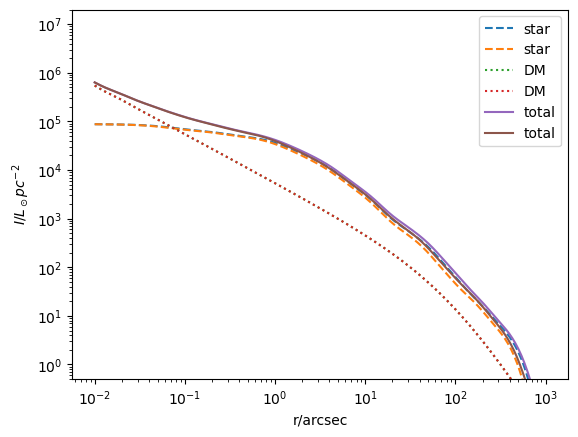

In [ ]:
from jam import total_mass_mge, mge1d_plot

rbreak = 10**2
gamma = -1
f_dm = bestfit[-1]
inc = 90

surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf, sigma, qObs, gamma, rbreak, f_dm, inc)

nmge = len(surf)
print(nmge,len(surf_pot))
radi, _, _ = mge1d_plot(surf, sigma, qObs, 1E-2, 1E3, label='star', linestyle='--')
mge1d_plot(surf_pot[nmge:], sigma_pot[nmge:], qobs_pot[nmge:], 1E-2, 1E3, label='DM', linestyle=':')
mge1d_plot(surf_pot, sigma_pot, qobs_pot, 1E-2, 1E3, label='total')

plt.legend()
# plt.xlim([0,5])
plt.ylim([0.5,2E7])

plt.show()

In [ ]:
# cosmo = FlatLambdaCDM(70, 0.3)
# z = 0.002626
# print('z:', z)
# print('Distance:', cosmo.comoving_distance(z))
# distance = cosmo.comoving_distance(z).to_value()  

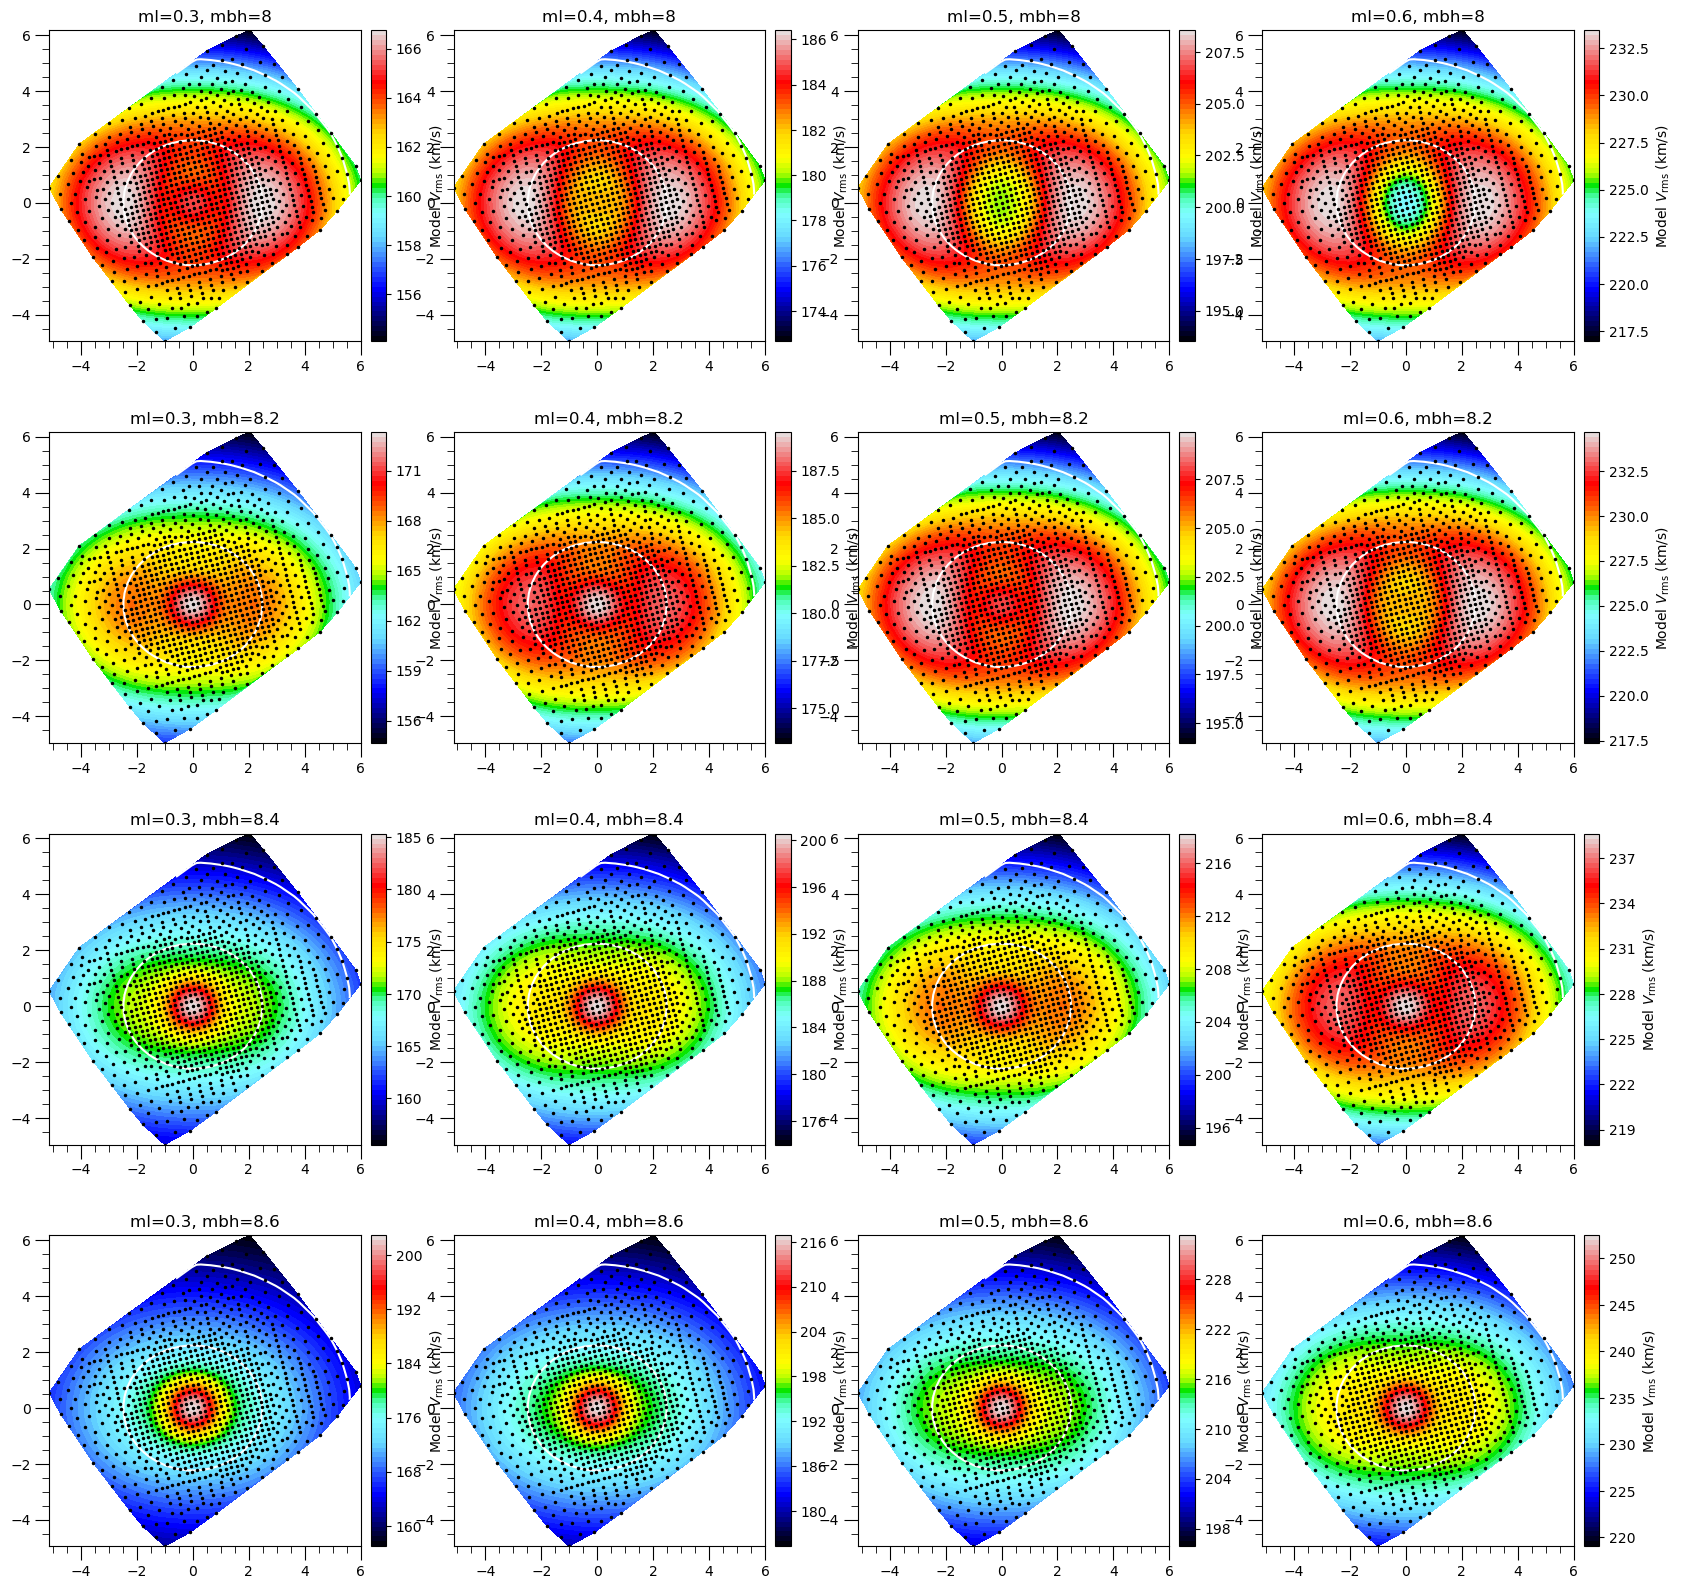

In [ ]:
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

ratio = 1

beta = np.full_like(qobs_lum, 1 - ratio**2)

plt.figure(figsize=[20,20])
rows = 4
columns = 4

listml = [0.3,0.4,0.5,0.6]
listmbh = [8,8.2,8.4,8.6]

for i in range(rows):
    for j in range(columns):

        ml = listml[j]
        mbh = listmbh[i]

        jam_test = jam.axi.proj(surf_lum, sigma_lum, qobs_lum, surf_pot*10**ml, sigma_pot, qobs_pot,
                       inc=90, mbh=10**mbh, distance=10, xbin=xbin, ybin=ybin, plot=True, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='sph',
                       beta=beta, errors=erms, ml=1, nodots=True)

        plt.subplot(rows, columns, 1+i*columns+j)
        plt.title('ml=%s, mbh=%s'%(ml,mbh))
        plot_velfield(xbin, ybin, jam_test.model, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=jam_test.flux)
        
# plt.xlabel('arcsec')
# plt.ylabel('arcsec')
plt.show()

10.280162981264723 2.9930900818058266


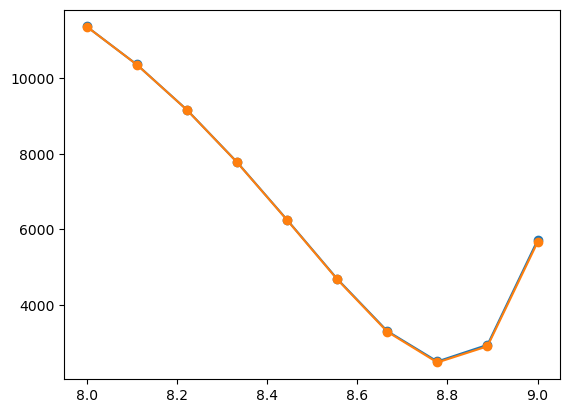

In [ ]:
mbh_plot = np.linspace(8,9,10)
ml_plot = np.linspace(50,90,5)
chi2_plot = np.zeros([len(mbh_plot),len(ml_plot)])
ml_fit = 10**bestfit[3]

print(distance,ml_fit)

for i,mbh in enumerate(mbh_plot):
    for j,ml in enumerate(ml_plot):
        jam_test = jam.axi.proj(surf_lum, sigma_lum, qobs_lum, surf_pot*ml_fit, sigma_pot, qobs_pot,
                        inc=ml, mbh=10**mbh, distance=distance, xbin=xbin, ybin=ybin, plot=False, pixsize=pixsize, quiet=1,
                        sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='cyl',
                        beta=beta, errors=erms, ml=1)

        resid = (rms[goodbins] - jam_test.model[goodbins])/erms[goodbins]
        chi2 = resid @ resid

        chi2_plot[i,j] = chi2  # ln(likelihood) + cost.


plt.plot(mbh_plot,chi2_plot[:,0],'-o')
plt.plot(mbh_plot,chi2_plot[:,1],'-o')

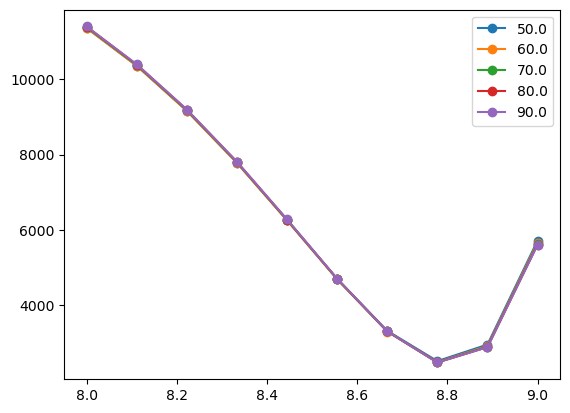

In [ ]:
plt.plot(mbh_plot,chi2_plot,'-o')
plt.legend(ml_plot)